In [1]:
from quests_data import *

from ase import Atoms
from ase.build import make_supercell
from quests.descriptor import get_descriptors, descriptor_pbc
from quests.entropy import perfect_entropy, get_bandwidth
from quests.tools.example import get_reference_structures
from quests.tools.plotting import savefig

CUTOFF = 5
K = 32

## Comparing descriptors of different structures

In [2]:
colors = {
    "fcc": cm.tab10(0),
    "bcc": cm.tab10(1),
    "hcp": cm.tab10(2),
}

In [3]:
import math

def polar2cart(r, theta, phi):
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

## Behavior under all-atoms displacements

In [4]:
ref, _, _ = get_reference_structures(frac=1.0, supercell=2)

In [5]:
fcc, bcc, hcp = get_reference_structures()

entropies = []
for name, struct in zip(["fcc", "bcc", "hcp"], [fcc, bcc, hcp]):
    vol = struct.get_volume() / len(struct)
    bw = 0.057
    st = make_supercell(struct, 25 * np.eye(3))
    rng = np.random.default_rng(1467)

    MAX_NOISE = 0.6

    for sigma in tqdm.tqdm(np.linspace(0, MAX_NOISE, 10)):
        spherical = rng.uniform(size=(len(st), 3)) * np.array([[sigma, np.pi, 2 * np.pi]])
        noise = np.array([polar2cart(r, theta, phi) for r, theta, phi in spherical])

        atoms = st.copy()
        atoms.translate(sigma * noise)

#         x1, x2 = descriptor_pbc(atoms.positions, np.array(atoms.cell))
        x = get_descriptors([atoms], k=K, cutoff=CUTOFF)
        H = perfect_entropy(x, h=bw)

        msd = np.sqrt(np.mean(spherical[:, 0] ** 2))

        entropies.append({
            "name": name,
            "sigma": sigma,
            "entropy": H,
            "msd": msd,
            "bw": bw,
        })

entropies = pd.DataFrame(entropies)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.58s/it]


### Distance

In [6]:
ref_fcc, ref_bcc, ref_hcp = get_reference_structures(frac=1.0, supercell=2)

In [7]:
distances = pd.Series({
    "fcc": np.min(ref_fcc.get_all_distances()[0, 1:]),
    "bcc": np.min(ref_bcc.get_all_distances()[0, 1:]),
    "hcp": np.min(ref_hcp.get_all_distances()[0, 1:]),
})

In [8]:
entropies["interatomic_dist"] = distances.reindex(entropies["name"]).values
entropies["fracs"] = entropies["msd"] / entropies["interatomic_dist"]

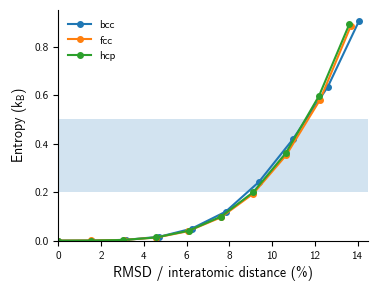

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

for name, grp in entropies.groupby("name"):
    ax.plot(grp["fracs"] * 100, grp["entropy"], "o-", markersize=4, label=name)

# ax.plot([0, grp["fracs"].max()], [1.3, 1.3], "--", label="liq")

ax.fill_between([0, 14.5], 0.5, 0.2, alpha=0.2)

ax.set_ylabel("Entropy (k$_B$)")
ax.set_xlabel("RMSD / interatomic distance (%)")
ax.set_ylim(bottom=0)
ax.set_xlim(0, 14.5)
ax.legend(frameon=False, ncol=1)

# savefig(fig, "01-lindemann.pdf")
plt.show()